# Police Shootings EDA

The Washington Post maintains a [database of fatal police shootings in the US](https://github.com/washingtonpost/data-police-shootings) since 2015.  We'll take a quick look at the data, and also analyze how biased shootings are by state or race.

Let's load the packages we'll need, load the dataset, and take a look at it.

In [4]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson 
import urllib.request, json 

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

In [7]:
PK = pd.read_csv('../input/fatal-police-shootings-data.csv', encoding='latin1')

In [8]:
PK.sample(n=10)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
2687,2984,Jeffory Hughes,2017-09-26,shot,gun,50.0,M,W,Fairview,TN,False,attack,Not fleeing,False
426,542,Raymond Phillips,2015-06-11,shot,gun,86.0,M,NaN,Columbia,TN,True,attack,Not fleeing,False
3155,3496,Justin Lee Dietrich,2018-03-12,shot,vehicle,32.0,M,W,West Fargo,ND,False,attack,Car,False
1589,1776,Jesse James Romero,2016-08-09,shot,gun,14.0,M,H,Los Angeles,CA,False,attack,Foot,True
343,439,Shaun Johnson,2015-05-08,shot,sword,35.0,M,W,Kearny,AZ,False,attack,Not fleeing,False
3015,3346,Humberto Vera-Munoz,2018-01-24,shot,unknown weapon,27.0,M,H,Sparks,NV,False,other,Foot,False
1822,2028,Kenton Kobza,2016-11-08,shot and Tasered,unarmed,19.0,M,W,Hays,KS,False,attack,Car,False
3150,3499,Juan Garcia Alvarez,2018-03-11,shot,gun,57.0,M,H,Midland,TX,False,attack,Not fleeing,False
1160,1323,Earl Hicks,2016-02-28,shot,gun,44.0,M,W,Rapid City,SD,True,attack,Not fleeing,False
964,1108,Guadalupe Quiroz,2015-12-21,shot,gun,34.0,M,H,Hemet,CA,False,attack,Not fleeing,False


In [9]:
# Show info about each column
for col in PK:
    print(col, '\nNum NaNs:', PK[col].isnull().sum())
    print(PK[col].describe(), '\n')

id 
Num NaNs: 0
count    3464.000000
mean     1950.032333
std      1085.502908
min         3.000000
25%      1017.750000
50%      1945.500000
75%      2892.250000
max      3824.000000
Name: id, dtype: float64 

name 
Num NaNs: 0
count      3464
unique     3349
top       TK TK
freq        105
Name: name, dtype: object 

date 
Num NaNs: 0
count           3464
unique          1193
top       2018-04-01
freq               9
Name: date, dtype: object 

manner_of_death 
Num NaNs: 0
count     3464
unique       2
top       shot
freq      3266
Name: manner_of_death, dtype: object 

armed 
Num NaNs: 6
count     3458
unique      77
top        gun
freq      1928
Name: armed, dtype: object 

age 
Num NaNs: 130
count    3334.000000
mean       36.829934
std        13.003941
min         6.000000
25%        27.000000
50%        35.000000
75%        45.000000
max        91.000000
Name: age, dtype: float64 

gender 
Num NaNs: 5
count     3459
unique       2
top          M
freq      3308
Name: gender, dtyp

Let's look at the distributions of these killings across the US.  We'll use [Bokeh](https://bokeh.pydata.org/en/latest/) to plot the number of killings in each city as a circle, where the area of the circle corresponds to the number of people shot by police in that city.

In [35]:
# Import bokeh components
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Circle, HoverTool, ColorBar, LinearColorMapper
from bokeh.palettes import Viridis256
from bokeh.tile_providers import CARTODBPOSITRON_RETINA
output_notebook()

# Functions to convert lat and lon to Mercator coords
def lat_to_mercY(lat):
    """Convert Latitude to Mercator Y"""
    return np.log(np.tan(np.pi / 4 + np.radians(lat) / 2)) * 6378137.0

def lon_to_mercX(lon):
    """Convert Longitude to Mercator X"""
    return np.radians(lon) * 6378137.0

# Count shootings per city
PK['citystate'] = PK.city.astype(str)+' '+PK.state.astype(str)
PKc = PK.citystate.value_counts().to_frame()

# this doesn't actually work in Kaggle Kernels b/c networking is disabled
# Look up latitude and longitude of each city using OSM geocoding
#cities = [c.replace(' ', '%20') for c in PKc.index.tolist()]
#Surl = 'http://nominatim.openstreetmap.org/search/' #search part of url
#Furl = '%20USA?format=json' #format part of url
#X = []
#Y = []
#for c in cities:
#    try:
#        with urllib.request.urlopen(Surl+c+Furl) as url:
#            data = json.loads(url.read().decode())
#        X.append(float(data[0]['lon']))
#        Y.append(float(data[0]['lat']))
#    except (IndexError, UnicodeEncodeError): #could not geocode this city
#        X.append(np.nan)
#        Y.append(np.nan)

# Load location data instead of geocoding it
CL = pd.read_csv('../input/CityLocations.csv')
PKcl = PKc.join(CL.set_index('city'))
X = PKcl.lon
Y = PKcl.lat

# Data source table for Bokeh
source = ColumnDataSource(data=dict(
    X = lon_to_mercX(X),
    Y = lat_to_mercY(Y),
    size = 7*np.sqrt(PKc.citystate),
    num_shot = PKc.citystate,
    city = PKc.index.tolist()
))

# Tooltips (on hover)
tooltips=[('People shot', "@num_shot"), 
          ('City', "@city")]

# Plot the points
p = figure(plot_width=800, plot_height=500, 
           x_range=(-7300000, -14500000), y_range=(2500000,7000000),
           title='Police Shootings by City', 
           active_scroll="wheel_zoom", tooltips=tooltips)
p.add_tile(CARTODBPOSITRON_RETINA) #set background map
p.circle('X', 'Y', source=source, size='size', #plot each station
         fill_alpha=0.5, line_color=None, color='crimson')
p.axis.visible = False
show(p)

Loading BokehJS ...

The Post is [only recording killings where the individual killed was shot by police](https://github.com/washingtonpost/data-police-shootings/blob/master/README.md).  Therefore, all the people killed by police in the dataset were shot, but around 6% were also tasered.

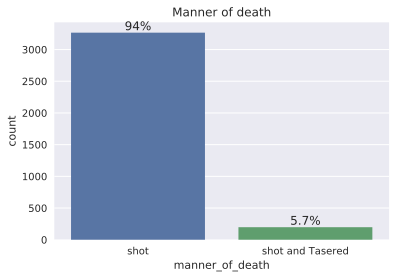

In [36]:
# Plot the manner of death
ax = sns.countplot(x='manner_of_death', data=PK)
plt.title('Manner of death')
for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2g}%'.format(100.*y/len(PK)), (x.mean(), y), ha='center', va='bottom')
plt.show()

The dataset also contains information about what type of weapon (if any) the individual killed was using.  The most common weapon by far was a gun followed by a knife, or a vehicle.  Though an alarmingly high proportion of individuals shot by police were unarmed or "armed" with a toy weapon.

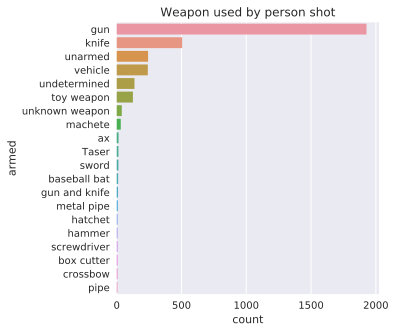

In [37]:
# Plot the 20 most common weapons used by individuals shot
plt.figure(figsize=(4.7, 5))
ax = sns.countplot(y='armed', data=PK,
                   order = PK.armed.value_counts().iloc[:20].index)
plt.title('Weapon used by person shot')
plt.show()

Most of the individuals shot and killed by police were between the ages of 20 and 40, with very few older than 80 or younger than 16.  Though there are 17 children under the age of 16 that were killed by police.

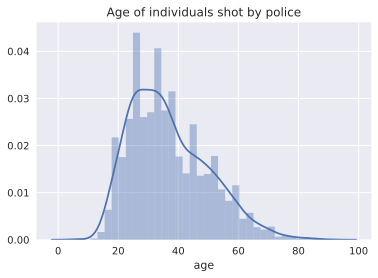

In [38]:
sns.distplot(PK.age[~np.isnan(PK.age)])
plt.title('Age of individuals shot by police')
plt.show()

In [39]:
PK[PK.age<16]

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,citystate
435,551,Zane Terryn,2015-06-14,shot,gun,15.0,M,W,Cocoa,FL,True,attack,Not fleeing,False,Cocoa FL
596,715,Andre Green,2015-08-09,shot,vehicle,15.0,M,B,Indianapolis,IN,False,attack,Not fleeing,False,Indianapolis IN
776,916,Jorge Santiago Tapia,2015-10-15,shot,gun,15.0,M,H,Miami,FL,False,attack,Car,False,Miami FL
833,980,Jeremy Mardis,2015-11-03,shot,unarmed,6.0,M,W,Marksville,LA,False,other,Car,True,Marksville LA
1018,1165,Ciara Meyer,2016-01-11,shot,unarmed,12.0,F,W,Penn Township,PA,False,other,Not fleeing,False,Penn Township PA
1298,1477,Jorevis Scruggs,2016-04-19,shot,gun,15.0,M,B,St. Louis,MO,False,attack,Other,False,St. Louis MO
1589,1776,Jesse James Romero,2016-08-09,shot,gun,14.0,M,H,Los Angeles,CA,False,attack,Foot,True,Los Angeles CA
1682,1883,Tyre King,2016-09-14,shot,toy weapon,13.0,M,B,Columbus,OH,False,other,Foot,False,Columbus OH
1849,2054,Luke Smith,2016-11-19,shot and Tasered,knife,15.0,M,A,Watsonville,CA,False,other,Foot,True,Watsonville CA
2271,2714,Daezion Turner,2017-04-24,shot,gun,15.0,M,B,Killeen,TX,False,attack,Not fleeing,False,Killeen TX


Most of the individuals shot by police were male.

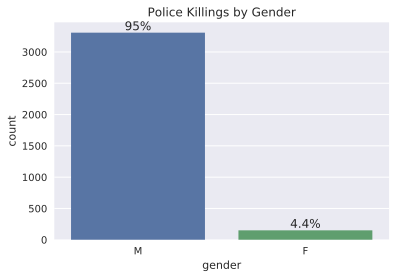

In [40]:
# Plot police killings by gender
ax = sns.countplot(x = "gender", data = PK,
                   order = PK.gender.value_counts().index)
for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2g}%'.format(100.*y/len(PK)), (x.mean(), y), ha='center', va='bottom')
plt.title('Police Killings by Gender')
plt.show()

According to the [US census](https://www.census.gov), the population of the United States is 50.8% female and 49.2% male.  How does this distribution match up to the distribution of police killings.  That is - if police were killing people completely at random, what would the killings distribution look like?

First let's define a function which will return a dataframe with the actual percentages and also the population percentages for any per-group count.

In [41]:
def ActualVsPopulation(df, pop, group):
    """Get dataframe with actual per-group percentage vs population group percentage"""
    d = {group: [], 'type': [], 'percent': []}
    tot_pop = float(sum(pop.values()))
    for g in df[group].dropna().unique(): #for each group

        # Actual percentages
        d[group].append(g)
        d['type'].append('Killings')
        d['percent'].append(100*df[df[group]==g].id.count()/df.id.count())

        # Percentages if statistic followed population distribution
        d[group].append(g)
        d['type'].append('Population') #based on population percentage
        d['percent'].append(100*pop[g]/tot_pop)
        
    return pd.DataFrame(data=d)

Now we can see the actual killings distribution versus the population distribution:

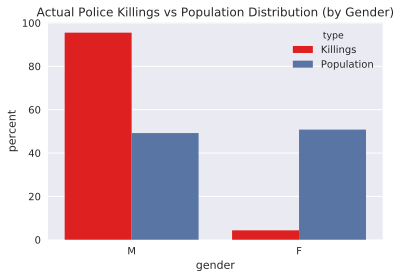

In [42]:
# Plot percent police killings by gender vs population percentages
pop_g = {'M': 49.2, 'F': 50.8} #percent population by gender https://www.census.gov/quickfacts/fact/table/US
df = ActualVsPopulation(PK, pop_g, 'gender')
sns.barplot(x="gender", y="percent", hue="type", data=df, palette=["r", "C0"])
plt.title('Actual Police Killings vs Population Distribution (by Gender)')
plt.show()

Next we'll plot the number of police killings by race.

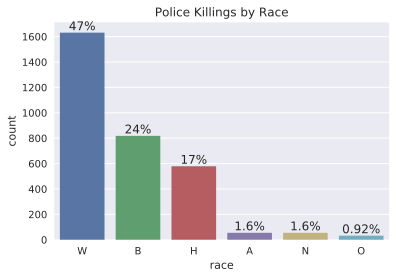

In [43]:
# Plot police killings by race
ax = sns.countplot(x="race", data=PK,
                   order = PK.race.value_counts().index)
for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2g}%'.format(100.*y/len(PK)), (x.mean(), y), ha='center', va='bottom')
plt.title('Police Killings by Race')
plt.show()

How does this match up to the population distribution?

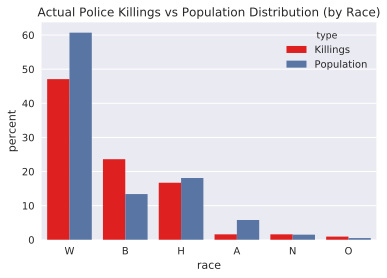

In [44]:
# Plot percent police killings by race vs population percentages
pop_r = {'W': 60.7, # white - % population by race https://www.census.gov/quickfacts/fact/table/US
         'B': 13.4, # black or african american
         'H': 18.1, # hispanic or latino
         'A': 5.8,  # asian
         'N': 1.5,  # american indian, alaska native, naitive hawaiian, and other pacific islander
         'O': 0.5}  # other
df = ActualVsPopulation(PK, pop_r, 'race')
sns.barplot(x="race", y="percent", hue="type", data=df,
            order = PK.race.value_counts().index, palette=["r", "C0"])
plt.title('Actual Police Killings vs Population Distribution (by Race)')
plt.show()

As you can see above, Black and Other are the only two racial categories with *more* police killings than would be expected if police killings were random.  And that effect isn't small - there are nearly *twice* as many police killings of black individuals than would be expected if these killings were random.  

Let's plot the number of police killings by state:

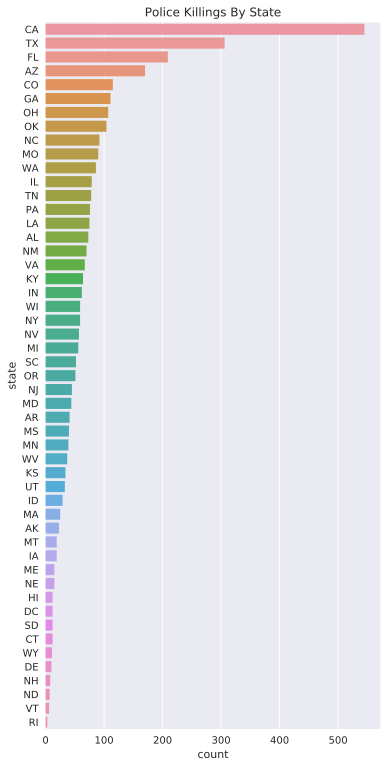

In [45]:
plt.figure(figsize=(6, 13))
sns.countplot(y="state", 
              data=PK,
              order=PK.state.value_counts().index)
plt.title('Police Killings By State')
plt.show()

And how does this match up to the population distribution of the states?

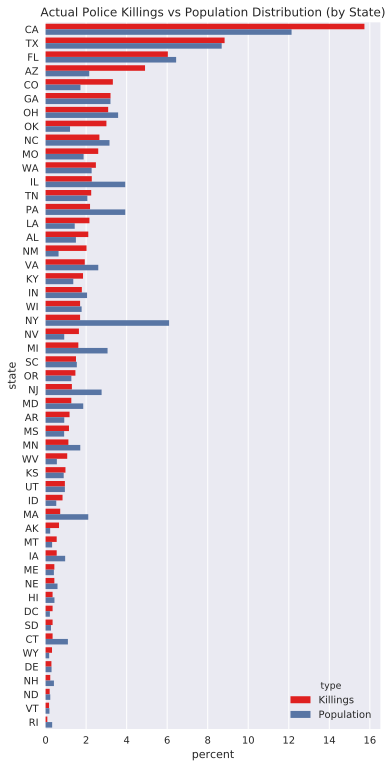

In [46]:
# Population for each state 
# https://www.census.gov/data/datasets/2017/demo/popest/state-total.html
pop_s ={'AL': 4874747,
        'AK': 739795,
        'AZ': 7016270,
        'AR': 3004279,
        'CA': 39536653,
        'CO': 5607154,
        'CT': 3588184,
        'DE': 961939,
        'DC': 693972,
        'FL': 20984400,
        'GA': 10429379,
        'HI': 1427538,
        'ID': 1716943,
        'IL': 12802023,
        'IN': 6666818,
        'IA': 3145711,
        'KS': 2913123,
        'KY': 4454189,
        'LA': 4684333,
        'ME': 1335907,
        'MD': 6052177,
        'MA': 6859819,
        'MI': 9962311,
        'MN': 5576606,
        'MS': 2984100,
        'MO': 6113532,
        'MT': 1050493,
        'NE': 1920076,
        'NV': 2998039,
        'NH': 1342795,
        'NJ': 9005644,
        'NM': 2088070,
        'NY': 19849399,
        'NC': 10273419,
        'ND': 755393,
        'OH': 11658609,
        'OK': 3930864,
        'OR': 4142776,
        'PA': 12805537,
        'RI': 1059639,
        'SC': 5024369,
        'SD': 869666,
        'TN': 6715984,
        'TX': 28304596,
        'UT': 3101833,
        'VT': 623657,
        'VA': 8470020,
        'WA': 7405743,
        'WV': 1815857,
        'WI': 5795483,
        'WY': 579315}

# Plot percent police killings by state vs population percentages
df = ActualVsPopulation(PK, pop_s, 'state')
plt.figure(figsize=(6, 13))
sns.barplot(y="state", x="percent", hue="type", data=df,
            order = PK.state.value_counts().index, palette=["r", "C0"])
plt.title('Actual Police Killings vs Population Distribution (by State)')
plt.show()

Instead of plotting both the actual killings against the population distributions, we can compute a single number - a score which tells us how likely it is to see a number of killings (for a state or race) if killings were random, given the population distribution.  We'll use a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) to model the likelihood of observing the number of killings given the number of people in a certain group (state or race).  

A Poisson distribution models the likelihood of observing some number of events ($k$ events) within a set time window, given the constant (or expected) rate for which they are thought to occur ($\lambda$ events per time window).  We want to know the likelihood of the number of police killings of people from a given state or of a given race, so we'll set the $\lambda$ parameter to be the number of individuals in a certain population (race or state) which we would expect to be killed by police given the national average, and find the probability at $k=$ the number of people killed by police in that population.   If police killings don't depend on state or race, then the number of people killed by police in that population ($k$) should be proportional to the population ($\lambda$).  The further $k$ is from $\lambda$, the less likely it is that police killlings are biased in that population.

But we don't just want to find the *likelihood* that police killings are biased in different populations, we also want to know the *direction* in which they are biased.  That is, are there more or less police killings of people in a certian population than would be expected in that population if killings were random?  Therefore, we'll use the cumulative probability of the Poisson distribution, which will tell us the likelihood of observing a given number of killings *or less*.  That way, if the value of the cumulative poisson distribution is closer to 0, that means there were less killings of a certain population than would be expected if killings were random.  If the value is closer to 1, there were more killings than would be expected if killings were random.  And if the value is around 0.5, police shootings of people in that population were relatively unbiased.

The cumulative probability of the Poisson distribution can be computed by:

$$
p(X \leq k) = e^{-\lambda} \sum_{i=0}^{\left \lfloor{k}\right \rfloor} \frac{\lambda^i}{i !}
$$

where again $k$ is the number of observed killings and $\lambda$ is the expected number of killings if killings were random (given the population distribution).

If there are $N_p$ individuals in a population, $N_k$ people shot and killed by police in the USA, and $N_{USA}$ people in the USA, we would expect to see, on average,

$$
\lambda = N_p \frac{N_k}{N_{USA}}
$$

people in that population shot by police if shootings were random.  Then the Poisson and cumulative Poisson distributions tell us how likely it is, if killings were random, to observe the actual number of people killed in that population:

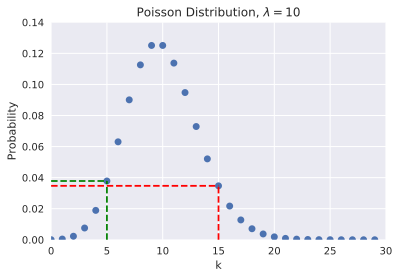

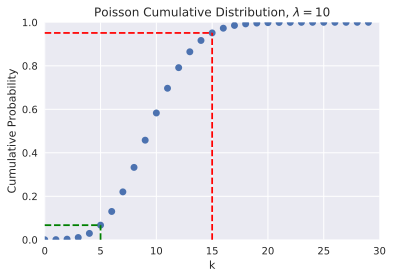

In [47]:
lam = 10 #lambda, the "expected" number
k1 = 5   #k, the actual number, when more than expected
k2 = 15  #k, the actual number, when less than expected

xx = np.arange(0,30)
ppd = poisson.pmf(xx, lam) #poisson probability distribution
cppd = poisson.cdf(xx, lam) #cumulative poisson distribution

p_k1 = poisson.pmf(k1, lam) #probability of observing k1
p_k2 = poisson.pmf(k2, lam) #and k2
c_k1 = poisson.cdf(k1, lam) #cumulative probability of observing k1
c_k2 = poisson.cdf(k2, lam) #and k2

plt.figure()
plt.plot(xx,ppd, 'o')
plt.plot([k1, k1], [0, p_k1], 'g--')
plt.plot([0, k1], [p_k1, p_k1], 'g--')
plt.plot([k2, k2], [0, p_k2], 'r--')
plt.plot([0, k2], [p_k2, p_k2], 'r--')
plt.title(r'Poisson Distribution, $\lambda=10$')
plt.xlabel('k')
plt.ylabel('Probability')
plt.xlim([0, 30])
plt.ylim([0, 0.14])
plt.show()

plt.figure()
plt.plot(xx,cppd, 'o')
c_k1 = poisson.cdf(k1, lam)
plt.plot([k1, k1], [0, c_k1], 'g--')
plt.plot([0, k1], [c_k1, c_k1], 'g--')
plt.plot([k2, k2], [0, c_k2], 'r--')
plt.plot([0, k2], [c_k2, c_k2], 'r--')
plt.title(r'Poisson Cumulative Distribution, $\lambda=10$')
plt.xlabel('k')
plt.ylabel('Cumulative Probability')
plt.xlim([0, 30])
plt.ylim([0, 1])
plt.show()

We can see that when there are less killings in a population than would be expected if killings were random, the cumulative probability value approaches 0, while when there are more than expected, the cumulative probability value approaches 1.

Let's plot that metric for each state, to see which states have less police killings than the national average ($p(X \leq k) \lessapprox 0.5$) and which states have more police killings than the national average ($p(X \leq k) \gtrapprox  0.5$).  I've plotted the bars such that they are anchored at 0.5 to make this distinction more clear.

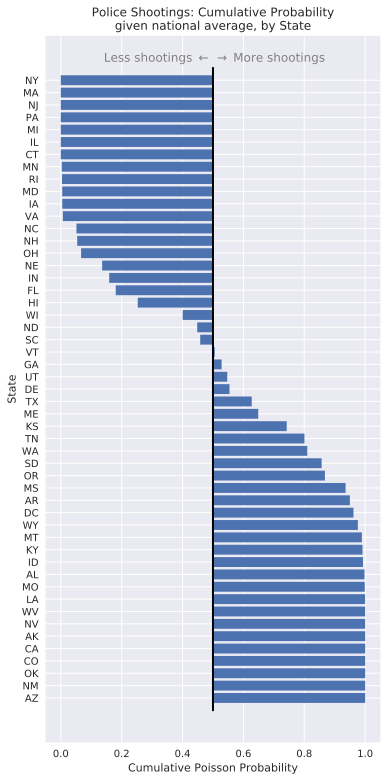

In [48]:
# Compute the cumulative Poisson distribution value for each state
natl_rate = PK.shape[0]/sum(pop_s.values()) #national average rate of police shootings per person
cum_poisson_vals = [] #to store cumulative poisson values
for state in pop_s.keys():
    lam = natl_rate*pop_s[state] #num shootings for this state if rate matched national avg (lambda)
    k = PK[PK.state==state].shape[0] #actual number of shootings in this state
    cum_poisson_vals.append(poisson.cdf(k, lam))

# Plot cumulative Poisson distribution values
plt.figure(figsize=(6, 13))
EK = pd.DataFrame(data={'state': list(pop_s.keys()), 
                        'cum_poisson': cum_poisson_vals})
EK.sort_values('cum_poisson', inplace=True)
y = np.arange(len(EK.state))
plt.barh(y, EK.cum_poisson-0.5, left=0.5)
ax = plt.gca()
ax.set_yticks(y)
ax.set_yticklabels(EK.state)
ax.invert_yaxis()
plt.plot([0.5, 0.5], [y[0]-1, y[-1]+1], 'k', linewidth=2)
plt.title('Police Shootings: Cumulative Probability\ngiven national average, by State')
plt.ylabel('State')
plt.xlabel('Cumulative Poisson Probability')
plt.text(0.505, y[0]-1.5, 
         r'Less shootings $\leftarrow$ $\rightarrow$ More shootings',
         horizontalalignment='center', color='gray')
plt.show()

So, Arizona has the highest frequency of police shootings given its population, while New York has the least.

We can plot the same statistic per race to see how racially biased police shootings are.

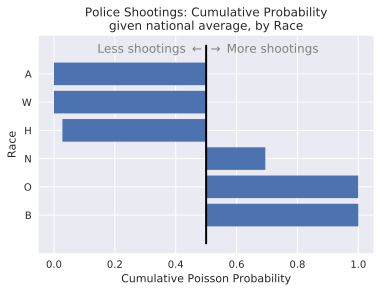

In [49]:
# Compute the cumulative Poisson distribution value for each race
cum_poisson_vals = []
for race in pop_r.keys():
    lam = PK.shape[0]*pop_r[race]/100 #num shootings of people of this race if killings were random (lambda)
    k = PK[PK.race==race].shape[0] #actual number of shootings of people of this race
    cum_poisson_vals.append(poisson.cdf(k, lam))

# Plot cumulative Poisson distribution values
plt.figure()
EK = pd.DataFrame(data={'race': list(pop_r.keys()), 
                        'cum_poisson': cum_poisson_vals})
EK.sort_values('cum_poisson', inplace=True)
y = np.arange(len(EK.race))
plt.barh(y, EK.cum_poisson-0.5, left=0.5)
plt.plot([0.5, 0.5], [y[0]-1, y[-1]+1], 'k', linewidth=2)
ax = plt.gca()
ax.set_yticks(y)
ax.set_yticklabels(EK.race)
ax.invert_yaxis()
plt.title('Police Shootings: Cumulative Probability\ngiven national average, by Race')
plt.ylabel('Race')
plt.xlabel('Cumulative Poisson Probability')
plt.text(0.506, y[0]-0.75, 
         r'Less shootings $\leftarrow$ $\rightarrow$ More shootings',
         horizontalalignment='center', color='gray')
plt.show()

This shows that police shootings are extremely racially biased: there is a near-zero probability of observing so few shootings of white and asian individuals if shootings were random, and a near-zero probability of observing so *many* shootings of black and other individuals if shootings were random.

To examine the dates of the shootings, we'll have to convert the dates which were loaded as general objects into datetimes.

In [50]:
# Convert date from object to datetime
PK.date = pd.to_datetime(PK.date)

And now we can see how the shooting frequency has changed over time:

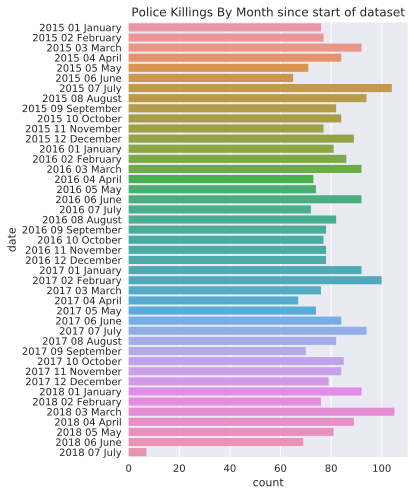

In [51]:
# Plot shootings by month
plt.figure(figsize=(5,8))
sns.countplot(y=PK.date.dt.strftime('%Y %m %B'), 
              order=sorted(PK.date.dt.strftime('%Y %m %B').unique()))
plt.title('Police Killings By Month since start of dataset')
plt.show()

Unfortunately it doesn't look like there is a decrease in the frequency of shootings.

We can also look at the number of killings as a function of the day of the week.

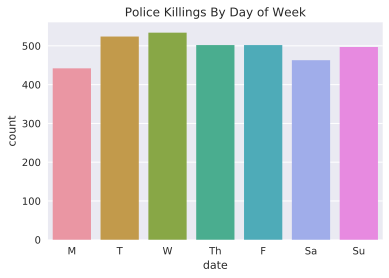

In [52]:
# Plot shootings by day of week
dow_map={0:'M', 1:'T', 2:'W', 3:'Th', 4:'F', 5:'Sa', 6:'Su'}
sns.countplot(x=PK.date.dt.dayofweek.map(dow_map), order=dow_map.values())
plt.title('Police Killings By Day of Week')
plt.show()

Unfortunately the dataset does not contain the times during the day of the shootings, so we can't analyze that.

Around a quarter of individuals shot and killed by police were experiencing a mental-health crisis, [according to the Washington Post](https://www.washingtonpost.com/national/how-the-washington-post-is-examining-police-shootings-in-the-united-states/2016/07/07/d9c52238-43ad-11e6-8856-f26de2537a9d_story.html) (the source of the database).

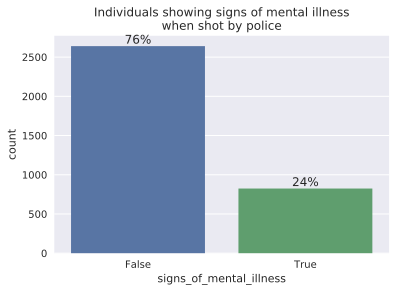

In [53]:
# Plot how many individuals showed signs of mental illness
ax = sns.countplot(x='signs_of_mental_illness', data=PK)
for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2g}%'.format(100.*y/len(PK)), (x.mean(), y), ha='center', va='bottom')
plt.title('Individuals showing signs of mental illness\nwhen shot by police')
plt.show()

Most individuals were not fleeing when they were shot by police.

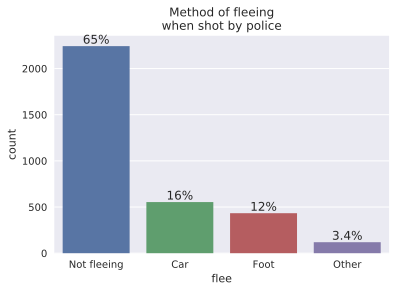

In [54]:
# Plot how many individuals were fleeing when shot
ax = sns.countplot(x='flee', data=PK)
for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2g}%'.format(100.*y/len(PK)), (x.mean(), y), ha='center', va='bottom')
plt.title('Method of fleeing\nwhen shot by police')
plt.show()

[According to the Post](https://github.com/washingtonpost/data-police-shootings/blob/master/README.md), "news reports have indicated an officer was wearing a body camera and it may have recorded some portion of the incident" during around 10% of the shootings.

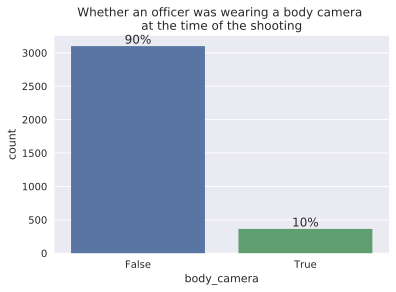

In [55]:
# Plot how many shootings have body camera footage
ax = sns.countplot(x='body_camera', data=PK)
for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2g}%'.format(100.*y/len(PK)), (x.mean(), y), ha='center', va='bottom')
plt.title('Whether an officer was wearing a body camera \nat the time of the shooting')
plt.show()

The percentages of police shootings where the officer was wearing a body camera varied widely between states.  In some states, officers were not wearing body cameras during the shootings.  Other states had higher rates of body camera usage.  However, keep in mind that for states with less shootings, we have a noisier estimate of actual body camera usage.

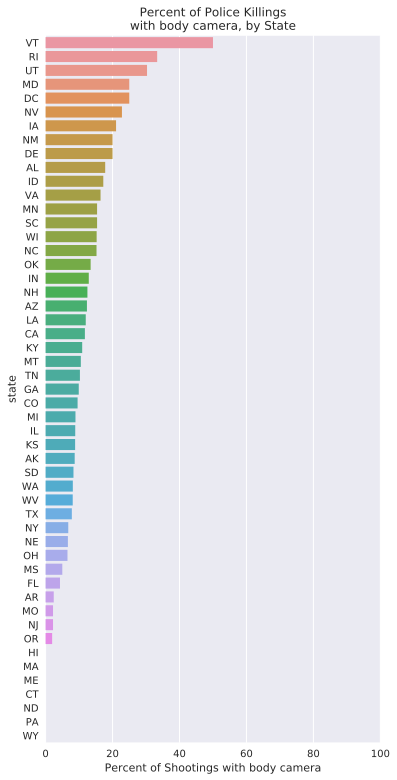

In [56]:
# Count the proportion of shootings w/ body camera by state
pcPK = PK.groupby('state').agg({'body_camera': 'mean'})

# Plot percent shootings w/ body camera by state
plt.figure(figsize=(6, 13))
sns.barplot(y=pcPK.index, 
            x=100.*pcPK.values.flatten(),
            order=pcPK.body_camera.sort_values(ascending=False).index)
plt.title('Percent of Police Killings\nwith body camera, by State')
plt.xlabel('Percent of Shootings with body camera')
plt.xlim([0, 100])
plt.show()